# Tables found in Section 6.4 :  Results From the Primary Evaluation

In [ ]:
import proplot as pplt
from matplotlib import pyplot as plt
import os
import pickle
import pandas as pd
from pathlib import Path

from tqdm import tqdm

from evaluation.fluctuation_analysis.anomaly_scores import AnomalyScores
from evaluation.fluctuation_analysis.metrics import Metrics
from evaluation.fluctuation_analysis.utils import get_cached_anomaly_scores

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = '#fbfbfb'



In [3]:
scenario_short = {
    "CVE-2017-7529": "2017",
    "CVE-2014-0160": "2014",
    "CVE-2012-2122": "2012",
    "Bruteforce_CWE-307": "BF",
    "CWE-89-SQL-injection": "SQL",
    "SQL_Injection_CWE-89": "SQL",
    "PHP_CWE-434": "PHP",
    "CVE-2018-3760": "2018",
    "CVE-2019-5418": "2019",
    "EPS_CWE-434": "EPS",
    "Juice-Shop": "JUIC",
    "ZipSlip": "ZIP",
    "CVE-2020-23839": "CMS",
    "CVE-2020-9484": "TOM",
    "CVE-2020-13942": "UNOM",
    "CVE-2017-12635_6": "CBD",
}

dataset_short = {
    "LID-DS-2019": "19",
    "LID-DS-2021": "21",
}

In [4]:
checkpoint_dir = "final"

scenario_2019 = [
    "CVE-2017-7529",
    "CVE-2012-2122",
    "Bruteforce_CWE-307",
    "CVE-2014-0160",
    "CVE-2018-3760",
    "CVE-2019-5418",
    "SQL_Injection_CWE-89",
    "PHP_CWE-434",
    "EPS_CWE-434",

    #"ZipSlip",
]

scenario_2021 = [
    "CVE-2017-7529",
    "Bruteforce_CWE-307",
    "CVE-2012-2122",
    "CVE-2014-0160",
    "CVE-2020-23839",
    "PHP_CWE-434",
    "CWE-89-SQL-injection",
    "EPS_CWE-434",  #296  ng32=2GB 1.5h

    #"CVE-2018-3760",        #115  ng32=19GB 0.5h
    #"CVE-2020-9484",        #223  ng32=18GB 1h

    #"ZipSlip",            #111  ng32=15GB 0.5h
    #"Juice-Shop"          #484  ng32=25GB 3.5h

    #"CVE-2019-5418",      #400  ng32>40GB(oom at 44%)

    #"CVE-2020-13942",     #846  ng32>40GB(oom a 100%) 43GB 4h
    #"CVE-2017-12635_6",   #1311 ng16=7GB  5h
]

datasets = [
    "LID-DS-2019",
    "LID-DS-2021",
]

In [5]:
def collect(config):
    path = os.path.join(checkpoint_dir, "metrics", f"{'_'.join((str(c) for c in config))}.pickle")
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    if os.path.exists(path):
        print("already processed: ", config)
        return

    ANOS_s: dict[int, AnomalyScores] = get_cached_anomaly_scores(config, base_path=checkpoint_dir)
    if len(ANOS_s) == 0:
        print("no cache found for: ", config)
        return

    metrics: dict[int, Metrics] = {}
    for _anos in tqdm(ANOS_s.values()):
        metrics[_anos.epoch] = Metrics(_anos)

    with open(path, 'wb') as f_out:
        pickle.dump(metrics, f_out)


In [6]:
configs_true = [
    ('TF', 'LID-DS-2021', 'CVE-2017-7529', 5, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2021', 'CVE-2017-7529', 8, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2021', 'CVE-2017-7529', 16, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 5, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 8, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, True),
]

In [28]:
for conf in configs_true:
    collect(conf)

already processed:  ('TF', 'LID-DS-2021', 'CVE-2017-7529', 5, 16, 2, 2, 0.1, True)
already processed:  ('TF', 'LID-DS-2021', 'CVE-2017-7529', 8, 16, 2, 2, 0.1, True)
already processed:  ('TF', 'LID-DS-2021', 'CVE-2017-7529', 16, 16, 2, 2, 0.1, True)
already processed:  ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 5, 16, 2, 2, 0.1, True)
already processed:  ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 8, 16, 2, 2, 0.1, True)
already processed:  ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, True)


In [7]:
all_metrics = {}

In [8]:

def load_metrics(config):
    path = os.path.join(checkpoint_dir, "metrics", f"{'_'.join((str(c) for c in config))}.pickle")
    if config in all_metrics:
        return all_metrics[config]
    with open(path, 'rb') as f_in:
        all_metrics[config] = pickle.load(f_in)
    return all_metrics[config]


In [9]:
for conf in configs_true:
    load_metrics(conf)

In [10]:
def early_stopping_min_or_no_improve_last_x(ths, x=10):
    ths_idx_best = 0
    x_since_best = 0
    for i, _th in enumerate(ths):
        if _th < ths[ths_idx_best]:
            ths_idx_best = i
            x_since_best = 0
        else:
            x_since_best += 1
        if x_since_best > x:
            break

    return ths_idx_best

In [11]:
def early_stopping_picked(_conf, _per, x=10, _train=False, _loss=False, _wait=0):
    """
    
    Returns:
        tp_ngs, fp_ngs, dr, epoch, precision, f1
    """
    metrics: list[Metrics] = list(load_metrics(_conf).values())
    if _loss:
        values = [_met.train_loss if _train else _met.val_loss for _met in metrics]
    else:
        values = [_met.threshold_train if _train else _met.threshold for _met in metrics]

    min_loss_idx = early_stopping_min_or_no_improve_last_x(values, x)
    min_loss_idx = min(min_loss_idx + _wait, len(metrics) - 1)
    picked = metrics[min_loss_idx]
    dr = picked.tpr[_per]
    fp_ngs = picked.fp_ngs[_per]
    tp_ngs = picked.tp_ngs[_per]
    # precision = picked.precision[_per]
    precision = picked.precision_ngs[_per]
    # f1 = picked.f1[_per]
    f1 = picked.f1_ngs[_per]

    return tp_ngs, fp_ngs, dr, picked.epoch, precision, f1


In [44]:
loss_picked = {}
ths_picked = {}
loss_picked_all = {}
ths_picked_all = {}

In [45]:
def collect_all_stats():
    not_found = set()
    for _m in [8,16,32]:
        for _n in [5, 8, 16, 32]:
            for _l in [2, 4]:
                _x = 25
                for loss in [False, True]:
                    for train in [False]:
                        pers = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                        for per in pers:
                            _res = []
                            for ds in datasets:
                                if ds == "LID-DS-2019":
                                    scenarios = scenario_2019
                                else:
                                    scenarios = scenario_2021

                                for scenario in scenarios:
                                    conf = ('TF', ds, scenario, _n, _m, _l, _l, 0.1, True)
                                    try:
                                        tp_ngs, fp_ngs, dr, epoch, precision, f1 = early_stopping_picked(conf, per, _x, train, loss)

                                        _res.append((tp_ngs, fp_ngs, dr, epoch, precision, f1))
                                    except Exception as e:
                                        not_found.add(conf)

                            res_pd = pd.DataFrame(_res, columns=["tp_ngs", "fp_ngs", "dr", "epoch", "precision", "f1", "cfa"])
                            if loss:
                                loss_picked[(_n, _l,_m, per)] = {}
                                loss_picked[(_n, _l,_m, per)]["fp_ngs"] = res_pd["fp_ngs"].mean()
                                loss_picked[(_n, _l,_m, per)]["dr"] = res_pd["dr"].mean()
                                loss_picked_all[(_n, _l,_m, per)] = {}
                                loss_picked_all[(_n, _l,_m, per)]["fp_ngs"] = [_r[1] for _r in _res]
                                loss_picked_all[(_n, _l,_m, per)]["dr"] = [_r[2] for _r in _res]
                            else:
                                ths_picked[(_n, _l,_m, per)] = {}
                                ths_picked[(_n, _l,_m, per)]["fp_ngs"] = res_pd["fp_ngs"].mean()
                                ths_picked[(_n, _l,_m, per)]["dr"] = res_pd["dr"].mean()
                                ths_picked_all[(_n, _l,_m, per)] = {}
                                ths_picked_all[(_n, _l,_m, per)]["fp_ngs"] = [_r[1] for _r in _res]
                                ths_picked_all[(_n, _l,_m, per)]["dr"] = [_r[2] for _r in _res]
                                

In [ ]:
collect_all_stats()

# STAT tests

In [60]:

from numpy import std, mean
from scipy.stats import ttest_rel, sem, ttest_ind, mannwhitneyu, wilcoxon
from itertools import chain

for per in [0, 20, 40, 60, 80]:
    print(f"PER {per}")
    print(f"ALL")
    print("LOSS")
    loss_picked_drs = [y["dr"] for x, y in loss_picked_all.items() if x[3] == per]
    loss_picked_drs = list(chain(*loss_picked_drs))
    print(len(loss_picked_drs))
    print(mean(loss_picked_drs))
    print(std(loss_picked_drs))
    print(sem(loss_picked_drs))

    print("THS")
    ths_picked_drs = [y["dr"] for x, y in ths_picked_all.items() if x[3] == per]
    ths_picked_drs = list(chain(*ths_picked_drs))
    print(len(ths_picked_drs))
    print(mean(ths_picked_drs))
    print(std(ths_picked_drs))
    print(sem(ths_picked_drs))

    print("TTEST")
    print(ttest_ind(loss_picked_drs, ths_picked_drs))
    print(ttest_rel(loss_picked_drs, ths_picked_drs))
    print(mannwhitneyu(loss_picked_drs, ths_picked_drs))
    print(wilcoxon(loss_picked_drs, ths_picked_drs))
    

PER 0
ALL
LOSS
340
0.8870073150506029
0.30137963171673565
0.01636869470703572
THS
340
0.8215415770323773
0.36898664348654864
0.020040603553069355
TTEST
TtestResult(statistic=2.529993070873355, pvalue=0.011631793112080901, df=678.0)
TtestResult(statistic=3.845606905810979, pvalue=0.00014362871892390497, df=339)
MannwhitneyuResult(statistic=62989.0, pvalue=0.010972603062531075)
WilcoxonResult(statistic=293.0, pvalue=2.087966662940871e-05)
PER 20
ALL
LOSS
340
0.8556169230153948
0.3382272891715889
0.018369984748145125
THS
340
0.7174413434830887
0.44006001263501887
0.0239007790890366
TTEST
TtestResult(statistic=4.583742106392335, pvalue=5.437939221206004e-06, df=678.0)
TtestResult(statistic=7.215632270254898, pvalue=3.5401760053923832e-12, df=339)
MannwhitneyuResult(statistic=67151.0, pvalue=1.0062802039246225e-05)
WilcoxonResult(statistic=162.0, pvalue=6.90767850724302e-12)
PER 40
ALL
LOSS
340
0.8063019406429733
0.382958835872699
0.02079946887603127
THS
340
0.6651527121290415
0.46416765671

In [64]:
per = 0
ngram_stats = [[],[]]
ngram_stats_drs = [[],[]]
ngram_stats_drs_ths = [[],[]]
ngram_stats_mean = [[],[]]
ngram_stats_mean_ths = [[],[]]
ngram_stats_fps = [[],[]]
ngram_stats_fps_ths = [[],[]]
results = {}
for n in [5, 8, 16, 32]: 
# for n in [5]: 
    print(f"N {n}")
    print(f"ALL")
    print("LOSS")
    loss_picked_drs = [y["dr"] for x,y in loss_picked_all.items() if x[3] == per and x[0] == n]
    loss_picked_drs = list(chain(*loss_picked_drs))
    print(len(loss_picked_drs))
    print(mean(loss_picked_drs))
    print(std(loss_picked_drs))
    print(sem(loss_picked_drs))
    ngram_stats[0].append((mean(loss_picked_drs), std(loss_picked_drs), sem(loss_picked_drs)))
    ngram_stats_drs[0].extend([n] * len(loss_picked_drs))
    ngram_stats_drs[1].extend(loss_picked_drs)
    ngram_stats_mean[0].append(n)
    ngram_stats_mean[1].append(mean(loss_picked_drs))
    
    print("\nFP-NGs")
    loss_picked_fps = [y["fp_ngs"] for x,y in loss_picked_all.items() if x[3] == per and x[0] == n]
    loss_picked_fps = list(chain(*loss_picked_fps))
    print(len(loss_picked_fps))
    print(mean(loss_picked_fps))
    print(std(loss_picked_fps))
    print(sem(loss_picked_fps))

    print("THS")
    ths_picked_drs = [y["dr"] for x,y in ths_picked_all.items() if x[3] == per and x[0] == n]
    ths_picked_drs = list(chain(*ths_picked_drs))
    print(len(ths_picked_drs))
    print(mean(ths_picked_drs))
    print(std(ths_picked_drs))
    print(sem(ths_picked_drs))
    ngram_stats[1].append((mean(ths_picked_drs), std(ths_picked_drs), sem(ths_picked_drs)))
    ngram_stats_drs_ths[0].extend([n] * len(ths_picked_drs))
    ngram_stats_drs_ths[1].extend(ths_picked_drs)
    ngram_stats_mean_ths[0].append(n)
    ngram_stats_mean_ths[1].append(mean(ths_picked_drs))


    print("\nFP-NGs")
    ths_picked_fps = [y["fp_ngs"] for x,y in ths_picked_all.items() if x[3] == per and x[0] == n]
    ths_picked_fps = list(chain(*ths_picked_fps))
    print(len(ths_picked_fps))
    print(mean(ths_picked_fps))
    print(std(ths_picked_fps))
    print(sem(ths_picked_fps))

    print("TTEST")
    print(ttest_ind(loss_picked_drs, ths_picked_drs))
    print(ttest_rel(loss_picked_drs, ths_picked_drs))
    print(mannwhitneyu(loss_picked_drs, ths_picked_drs))
    print(wilcoxon(loss_picked_drs, ths_picked_drs))

    print("\nTTEST FP-NGs")
    print(ttest_ind(loss_picked_fps, ths_picked_fps))
    print(ttest_rel(loss_picked_fps, ths_picked_fps))
    print(mannwhitneyu(loss_picked_fps, ths_picked_fps))
    print(wilcoxon(loss_picked_fps, ths_picked_fps))


# correlation
import scipy.stats as stats
print(" DR ALL ")
print(stats.pearsonr(ngram_stats_drs[0], ngram_stats_drs[1]))
print(stats.spearmanr(ngram_stats_drs[0], ngram_stats_drs[1]))
print(stats.kendalltau(ngram_stats_drs[0], ngram_stats_drs[1]))

print(" DR  ALL THS")
print(stats.pearsonr(ngram_stats_drs_ths[0], ngram_stats_drs_ths[1]))
print(stats.spearmanr(ngram_stats_drs_ths[0], ngram_stats_drs_ths[1]))
print(stats.kendalltau(ngram_stats_drs_ths[0], ngram_stats_drs_ths[1]))

print(" MEAN  ")
print(stats.pearsonr(ngram_stats_mean[0], ngram_stats_mean[1]))
print(stats.spearmanr(ngram_stats_mean[0], ngram_stats_mean[1]))
print(stats.kendalltau(ngram_stats_mean[0], ngram_stats_mean[1]))

print(" MEAN THS ")
print(stats.pearsonr(ngram_stats_mean_ths[0], ngram_stats_mean_ths[1]))
print(stats.spearmanr(ngram_stats_mean_ths[0], ngram_stats_mean_ths[1]))
print(stats.kendalltau(ngram_stats_mean_ths[0], ngram_stats_mean_ths[1]))
print(len(ngram_stats_drs[0]))
print(len(ngram_stats_drs_ths[0]))
print(len(ngram_stats_mean[0]))
print(len(ngram_stats_mean_ths[0]))



N 5
ALL
LOSS
102
0.928692066370486
0.24378387781382513
0.024257402479836387

FP-NGs
102
20.215686274509803
28.504773405203004
2.836330963668562
THS
102
0.7673061116448199
0.4055832464186093
0.040357041391261866

FP-NGs
102
19.34313725490196
32.89481009724942
3.273155941165824
TTEST
TtestResult(statistic=3.4274559645914113, pvalue=0.0007382226118402436, df=202.0)
TtestResult(statistic=4.634579977630271, pvalue=1.071019322914014e-05, df=101)
MannwhitneyuResult(statistic=6226.0, pvalue=0.0031489382730173466)
WilcoxonResult(statistic=5.5, pvalue=9.183691275099125e-06)

TTEST FP-NGs
TtestResult(statistic=0.20146185490529067, pvalue=0.8405401786722756, df=202.0)
TtestResult(statistic=0.5442071004409758, pvalue=0.587498388729788, df=101)
MannwhitneyuResult(statistic=5938.5, pvalue=0.07839715526361452)
WilcoxonResult(statistic=1708.5, pvalue=0.38419354773954517)
N 8
ALL
LOSS
102
0.8786893556087618
0.31599967897730663
0.03144314326768378

FP-NGs
102
44.22549019607843
103.54869147948055
10.30347

In [97]:
per = 0
layer_stats = [[],[]]
layer_stats_drs = [[],[]]
layer_stats_drs_ths = [[],[]]
layer_stats_mean = [[],[]]
layer_stats_mean_ths = [[],[]]

for l in [2, 4]: 
    print(f"L {l}")
    print(f"ALL")
    print("LOSS")
    loss_picked_drs = [[y[1] for y in _y] for x,_y in loss_picked_all.items() if x[3] == per and x[1] == l]
    loss_picked_drs = list(chain(*loss_picked_drs))
    print(len(loss_picked_drs))
    print(mean(loss_picked_drs))
    print(std(loss_picked_drs))
    print(sem(loss_picked_drs))
    layer_stats[0].append((mean(loss_picked_drs), std(loss_picked_drs), sem(loss_picked_drs)))
    layer_stats_drs[0].extend([l] * len(loss_picked_drs))
    layer_stats_drs[1].extend(loss_picked_drs)
    layer_stats_mean[0].append(l)
    layer_stats_mean[1].append(mean(loss_picked_drs))
    
    print("THS")
    ths_picked_drs = [[y[1] for y in _y] for x,_y in ths_picked_all.items() if x[3] == per and x[1] == l]
    ths_picked_drs = list(chain(*ths_picked_drs))
    print(len(ths_picked_drs))
    print(mean(ths_picked_drs))
    print(std(ths_picked_drs))
    print(sem(ths_picked_drs))
    layer_stats[1].append((mean(ths_picked_drs), std(ths_picked_drs), sem(ths_picked_drs)))
    layer_stats_drs_ths[0].extend([l] * len(ths_picked_drs))
    layer_stats_drs_ths[1].extend(ths_picked_drs)
    layer_stats_mean_ths[0].append(l)
    layer_stats_mean_ths[1].append(mean(ths_picked_drs))
    
    print("TTEST")
    print(ttest_ind(loss_picked_drs, ths_picked_drs))
    print(ttest_rel(loss_picked_drs, ths_picked_drs))
    print(mannwhitneyu(loss_picked_drs, ths_picked_drs))
    print(wilcoxon(loss_picked_drs, ths_picked_drs))
    

print(layer_stats)
# print(layer_stats_drs)
print(layer_stats_mean)
print(layer_stats_mean_ths)
# corelation
import scipy.stats as stats
print(" DR ALL ")
print(stats.pearsonr(layer_stats_drs[0], layer_stats_drs[1]))
print(stats.spearmanr(layer_stats_drs[0], layer_stats_drs[1]))
print(stats.kendalltau(layer_stats_drs[0], layer_stats_drs[1]))

print(" DR  ALL THS")
print(stats.pearsonr(layer_stats_drs_ths[0], layer_stats_drs_ths[1]))
print(stats.spearmanr(layer_stats_drs_ths[0], layer_stats_drs_ths[1]))
print(stats.kendalltau(layer_stats_drs_ths[0], layer_stats_drs_ths[1]))

print(" MEAN  ")
print(stats.pearsonr(layer_stats_mean[0], layer_stats_mean[1]))
print(stats.spearmanr(layer_stats_mean[0], layer_stats_mean[1]))
print(stats.kendalltau(layer_stats_mean[0], layer_stats_mean[1]))

print(" MEAN THS ")
print(stats.pearsonr(layer_stats_mean_ths[0], layer_stats_mean_ths[1]))
print(stats.spearmanr(layer_stats_mean_ths[0], layer_stats_mean_ths[1]))
print(stats.kendalltau(layer_stats_mean_ths[0], layer_stats_mean_ths[1]))
print(len(layer_stats_drs[0]))
print(len(layer_stats_drs_ths[0]))
print(len(layer_stats_mean[0]))
print(len(layer_stats_mean_ths[0]))

layer_2_stats_drs = [y for x,y in zip(layer_stats_drs[0], layer_stats_drs[1]) if x == 2]
layer_4_stats_drs = [y for x,y in zip(layer_stats_drs[0], layer_stats_drs[1]) if x == 4]
layer_2_stats_drs_ths = [y for x,y in zip(layer_stats_drs_ths[0], layer_stats_drs_ths[1]) if x == 2]
layer_4_stats_drs_ths = [y for x,y in zip(layer_stats_drs_ths[0], layer_stats_drs_ths[1]) if x == 4]
print(mannwhitneyu(layer_2_stats_drs, layer_4_stats_drs))
print(mannwhitneyu(layer_2_stats_drs_ths, layer_4_stats_drs_ths))
print(wilcoxon(layer_2_stats_drs, layer_4_stats_drs))
print(wilcoxon(layer_2_stats_drs_ths, layer_4_stats_drs_ths))
# trel
print(ttest_rel(layer_2_stats_drs, layer_4_stats_drs))
print(ttest_rel(layer_2_stats_drs_ths, layer_4_stats_drs_ths))


L 2
ALL
LOSS
170
0.879289892597751
0.3100621463904758
0.023850934337728905
THS
170
0.8446344190646364
0.34739874647225777
0.02672298049786598
TTEST
TtestResult(statistic=0.9675225355235043, pvalue=0.3339746587407043, df=338.0)
TtestResult(statistic=1.580558197129169, pvalue=0.11584886954700642, df=169)
MannwhitneyuResult(statistic=15628.5, pvalue=0.10264336487004268)
WilcoxonResult(statistic=120.5, pvalue=0.03548835684074841)
L 4
ALL
LOSS
170
0.8947247375034552
0.29223571476554683
0.02247967036658052
THS
170
0.7984487350001178
0.388007523620598
0.029846732586199843
TTEST
TtestResult(statistic=2.576617684766356, pvalue=0.010400978813029826, df=338.0)
TtestResult(statistic=3.7176863774641586, pvalue=0.0002731507173146552, df=169)
MannwhitneyuResult(statistic=15866.0, pvalue=0.04984253262961724)
WilcoxonResult(statistic=43.5, pvalue=0.0002601046919959213)
[[(0.879289892597751, 0.3100621463904758, 0.023850934337728905), (0.8947247375034552, 0.29223571476554683, 0.02247967036658052)], [(0.8

In [98]:
per = 0
emb_stats = [[],[]]
emb_stats_drs = [[],[]]
emb_stats_drs_ths = [[],[]]
emb_stats_mean = [[],[]]
emb_stats_mean_ths = [[],[]]

for m in [8, 16, 32]: 
    print(f"M {m}")
    print(f"ALL")
    print("LOSS")
    loss_picked_drs = [[y[1] for y in _y] for x,_y in loss_picked_all.items() if x[3] == per and x[2] == m]
    loss_picked_drs = list(chain(*loss_picked_drs))
    print(len(loss_picked_drs))
    print(mean(loss_picked_drs))
    print(std(loss_picked_drs))
    print(sem(loss_picked_drs))
    emb_stats[0].append((mean(loss_picked_drs), std(loss_picked_drs), sem(loss_picked_drs)))
    emb_stats_drs[0].extend([m] * len(loss_picked_drs))
    emb_stats_drs[1].extend(loss_picked_drs)
    emb_stats_mean[0].append(m)
    emb_stats_mean[1].append(mean(loss_picked_drs))
    
    print("THS")
    ths_picked_drs = [[y[1] for y in _y] for x,_y in ths_picked_all.items() if x[3] == per and x[2] == m]
    ths_picked_drs = list(chain(*ths_picked_drs))
    print(len(ths_picked_drs))
    print(mean(ths_picked_drs))
    print(std(ths_picked_drs))
    print(sem(ths_picked_drs))
    emb_stats[1].append((mean(ths_picked_drs), std(ths_picked_drs), sem(ths_picked_drs)))
    emb_stats_drs_ths[0].extend([m] * len(ths_picked_drs))
    emb_stats_drs_ths[1].extend(ths_picked_drs)
    emb_stats_mean_ths[0].append(m)
    emb_stats_mean_ths[1].append(mean(ths_picked_drs))
    
    print("TTEST")
    print(ttest_ind(loss_picked_drs, ths_picked_drs))
    print(ttest_rel(loss_picked_drs, ths_picked_drs))

print(emb_stats)
# print(emb_stats_drs)
print(emb_stats_mean)
print(emb_stats_mean_ths)
# corelation
import scipy.stats as stats
print(" DR ALL ")
print(stats.pearsonr(emb_stats_drs[0], emb_stats_drs[1]))
print(stats.spearmanr(emb_stats_drs[0], emb_stats_drs[1]))
print(stats.kendalltau(emb_stats_drs[0], emb_stats_drs[1]))

print(" DR  ALL THS")
print(stats.pearsonr(emb_stats_drs_ths[0], emb_stats_drs_ths[1]))
print(stats.spearmanr(emb_stats_drs_ths[0], emb_stats_drs_ths[1]))
print(stats.kendalltau(emb_stats_drs_ths[0], emb_stats_drs_ths[1]))

print(" MEAN  ")
print(stats.pearsonr(emb_stats_mean[0], emb_stats_mean[1]))
print(stats.spearmanr(emb_stats_mean[0], emb_stats_mean[1]))
print(stats.kendalltau(emb_stats_mean[0], emb_stats_mean[1]))

print(" MEAN THS ")
print(stats.pearsonr(emb_stats_mean_ths[0], emb_stats_mean_ths[1]))
print(stats.spearmanr(emb_stats_mean_ths[0], emb_stats_mean_ths[1]))
print(stats.kendalltau(emb_stats_mean_ths[0], emb_stats_mean_ths[1]))
print(len(emb_stats_drs[0]))
print(len(emb_stats_drs_ths[0]))
print(len(emb_stats_mean[0]))
print(len(emb_stats_mean_ths[0]))


M 8
ALL
LOSS
102
0.8640063856465834
0.33419930071922593
0.033254073315780175
THS
102
0.6206270344786204
0.4740061467293309
0.04716537443838172
TTEST
TtestResult(statistic=4.217306282530408, pvalue=3.730197447628704e-05, df=202.0)
TtestResult(statistic=5.453070069007763, pvalue=3.5255046032636274e-07, df=101)
M 16
ALL
LOSS
136
0.8926434049704419
0.2888576776579993
0.02486091055541292
THS
136
0.8960734617723672
0.28640131476467273
0.024649500498121906
TTEST
TtestResult(statistic=-0.0979751232872112, pvalue=0.9220247401739707, df=270.0)
TtestResult(statistic=-0.20769752533792932, pvalue=0.835778142229091, df=135)
M 32
ALL
LOSS
102
0.9024934578948376
0.2810934734249696
0.027969845998314802
THS
102
0.9230802732661473
0.2484034412056988
0.024717066217581077
TTEST
TtestResult(statistic=-0.5515378504154973, pvalue=0.5818746212522824, df=202.0)
TtestResult(statistic=-1.160126811332168, pvalue=0.2487321954898587, df=101)
[[(0.8640063856465834, 0.33419930071922593, 0.033254073315780175), (0.89264

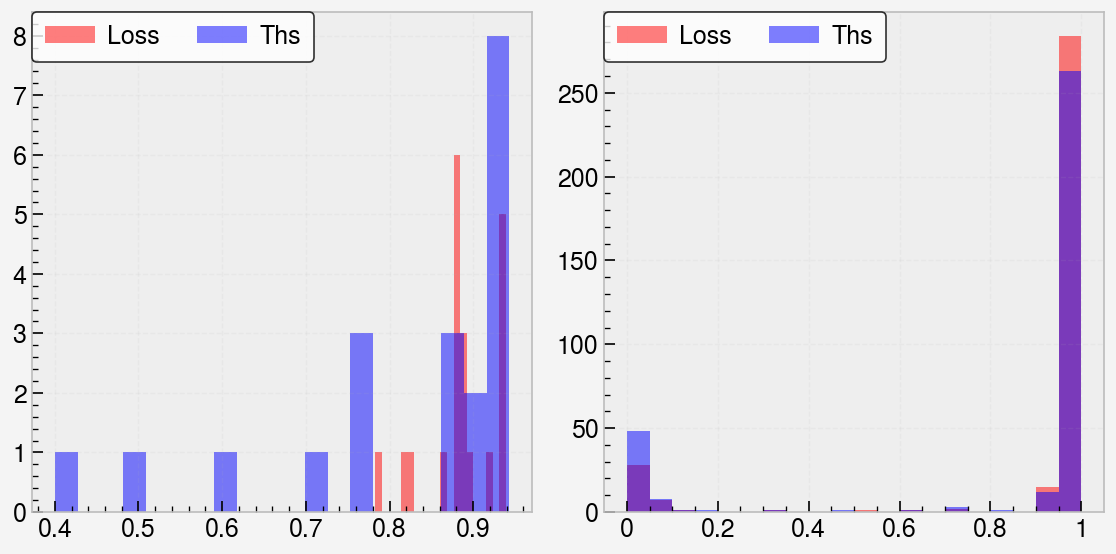

In [48]:
# plot dr distribution
loss_picked_drs = [y[2] for x,y in loss_picked.items() if x[3] == 0]
ths_picked_drs = [y[2] for x,y in ths_picked.items() if x[3] == 0]
loss_picked_all_drs = [[y[1] for y in _y] for x,_y in loss_picked_all.items() if x[3] == 0 ]
loss_picked_all_drs = list(chain(*loss_picked_all_drs))
ths_picked_all_drs = [[y[1] for y in _y] for x,_y in ths_picked_all.items() if x[3] == 0 ]
ths_picked_all_drs = list(chain(*ths_picked_all_drs))
fig, axs = pplt.subplots(ncols=2, nrows=1, sharex=True, sharey=False, refwidth=2.5, refheight=2.5, )
ax = axs[0]
ax.hist(loss_picked_drs, bins=20, label="Loss", color='red', alpha=0.5)
ax.hist(ths_picked_drs, bins=20, label="Ths", color='blue', alpha=0.5)
ax.legend()
ax = axs[1]
ax.hist(loss_picked_all_drs, bins=20, label="Loss", color='red', alpha=0.5)
ax.hist(ths_picked_all_drs, bins=20, label="Ths", color='blue', alpha=0.5)
ax.legend()



# ALL SCENARIOS, Tables

In [47]:
scenario_2019 = [
    "CVE-2017-7529",
    "CVE-2012-2122",
    "Bruteforce_CWE-307",
    "CVE-2014-0160",
    "CVE-2018-3760",
    "CVE-2019-5418",
    "SQL_Injection_CWE-89",
    "PHP_CWE-434",
    "EPS_CWE-434",
    "ZipSlip",
]

scenario_2021 = [
    "CVE-2017-7529",
    "Bruteforce_CWE-307",
    "CVE-2012-2122",
    "CVE-2014-0160",
    "CVE-2020-23839",
    "PHP_CWE-434",
    "CWE-89-SQL-injection",
    "EPS_CWE-434",  #296  ng32=2GB 1.5h

    "CVE-2018-3760",        #115  ng32=19GB 0.5h
    "CVE-2020-9484",        #223  ng32=18GB 1h

    "ZipSlip",            #111  ng32=15GB 0.5h
    "Juice-Shop",          #484  ng32=25GB 3.5h

    "CVE-2019-5418",      #400  ng32>40GB(oom at 44%)

    "CVE-2020-13942",     #846  ng32>40GB(oom a 100%) 43GB 4h
    "CVE-2017-12635_6",   #1311 ng16=7GB  5h
]

datasets = [
    "LID-DS-2019",
    "LID-DS-2021"
]


In [9]:

def get_cfa_stats(conf):
    stats_path = os.path.join(checkpoint_dir,"metrics", f"{'_'.join((str(c) for c in conf))}_stats.pickle")
    if not os.path.exists(stats_path):
        print("not found", stats_path)
        raise Exception("not found ", stats_path)
    with open(stats_path, "rb") as f:
        stats = pickle.load(f)

    return stats["consecutive_false_positives_normal"] + stats["consecutive_false_positives_exploits"]


In [14]:
ngs = [4,5,6,7,8]

def get_results_by_earlystopping():
    _picked_epochs = []
    _x = 25
    for _n in ngs:
        for _m in [8, 16, 32]:
            for _l in [2, 4]:
                for loss in [True, False]:
                    pers = [0, 10, 20, 30, 40]
                    for per in pers:
                        for ds in datasets:
                            if ds == "LID-DS-2019":
                                scenarios = scenario_2019
                            else:
                                scenarios = scenario_2021
                            for scenario in scenarios:
                                conf = ('TF', ds, scenario, _n, _m, _l, _l, 0.1, True)
                                try:
                                    tp_ngs, fp_ngs, dr, epoch, precision, f1 = early_stopping_picked(
                                        conf,
                                        per,
                                        _x,
                                        _train=False,
                                        _loss=loss
                                    )
                                    conf_ep_per = conf + (epoch, per)
                                    default_cfa = 0 if fp_ngs == 0 else math.inf
                                    cfa = config_to_cfa.get(conf_ep_per, default_cfa)
                                    # if conf_ep_per in config_to_cfa:
                                    #     print("found: ", conf)
                                    _picked_epochs.append(conf + (loss, epoch, per, tp_ngs, fp_ngs, dr, precision, f1, cfa))
                                except:
                                    # print("failed: ", conf)
                                    pass

    _picked_epochs = pd.DataFrame(
        _picked_epochs,
        columns=["algo", "dataset", "scenario", "n", "m", "l", "l2", "do", "split", "loss", "epoch", "per", "tp_ngs", "fp_ngs",
                 "dr", "precision", "f1", "cfa"]
    )
    # picked_epochs.to_csv("picked_epochs.csv", index=False)
    return _picked_epochs

In [215]:
import math

def get_results_by_fixed_epochs():
    not_found = set()
    _picked_epochs = []
    for _n in ngs:
        for _m in [8, 16, 32]:
            for _l in [2, 4]:
                pers = [0, 10, 20, 30, 40]
                for per in pers:
                    epochs = list(range(1, 900, 50))
                    for epoch in epochs:
                        for ds in datasets:
                            if ds == "LID-DS-2019":
                                scenarios = scenario_2019
                            else:
                                scenarios = scenario_2021
                            for scenario in scenarios:
                                conf = ('TF', ds, scenario, _n, _m, _l, _l, 0.1, True)
                                try:
                                    metrics: dict[int, Metrics] = load_metrics(conf)
                                    picked = metrics[epoch]
                                    dr = picked.tpr[per]
                                    fp_ngs = picked.fp_ngs[per]
                                    tp_ngs = picked.tp_ngs[per]
                                    precision = picked.precision_ngs[per]
                                    f1 = picked.f1_ngs[per]

                                    conf_ep_per = conf + (epoch, per)
                                    default_cfa = 0 if fp_ngs == 0 else math.inf
                                    cfa = config_to_cfa.get(conf_ep_per, default_cfa)
                                    _picked_epochs.append(conf + (epoch, per, tp_ngs, fp_ngs, dr, precision, f1, cfa))
                                except Exception:
                                    # print("failed: ", conf)
                                    not_found.add(conf)
                                    pass
    print(list(not_found))
    _picked_epochs = pd.DataFrame(
        _picked_epochs,
        columns=["algo", "dataset", "scenario", "n", "m", "l", "l2", "do", "split",  "epoch", "per", "tp_ngs", "fp_ngs", "dr", "precision", "f1", "cfa"],
    )
    return _picked_epochs


In [216]:
picked_early = get_results_by_earlystopping()
picked_early

,algo,dataset,scenario,n,m,l,l2,do,split,loss,epoch,per,tp_ngs,fp_ngs,dr,precision,f1,cfa
0,TF,LID-DS-2019,CVE-2017-7529,4,8,2,2,0.1,True,True,871,0,5,0,0.988506,1.000000,0.994220,0.0
1,TF,LID-DS-2019,CVE-2012-2122,4,8,2,2,0.1,True,True,896,0,6,26,0.987097,0.854749,0.916168,46.0
2,TF,LID-DS-2019,Bruteforce_CWE-307,4,8,2,2,0.1,True,True,891,0,15,13,0.602041,0.819444,0.694118,8.0
3,TF,LID-DS-2019,CVE-2014-0160,4,8,2,2,0.1,True,True,896,0,2,2,0.010000,0.333333,0.019417,4.0
4,TF,LID-DS-2019,CVE-2018-3760,4,8,2,2,0.1,True,True,896,0,171,4,1.000000,0.971631,0.985612,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,TF,LID-DS-2021,ZipSlip,8,32,4,4,0.1,True,False,61,40,2,9,0.805085,0.913462,0.855856,inf
7496,TF,LID-DS-2021,Juice-Shop,8,32,4,4,0.1,True,False,56,40,254,25,0.619835,0.750000,0.678733,inf
7497,TF,LID-DS-2021,CVE-2019-5418,8,32,4,4,0.1,True,False,146,40,1,21,0.025000,0.125000,0.041667,inf
7498,TF,LID-DS-2021,CVE-2020-13942,8,32,4,4,0.1,True,False,111,40,404,0,1.000000,1.000000,1.000000,0.0


In [156]:
picked_epoch = get_results_by_fixed_epochs()
picked_epoch

[]


,algo,dataset,scenario,n,m,l,l2,do,split,epoch,per,tp_ngs,fp_ngs,dr,precision,f1,cfa
0,TF,LID-DS-2019,CVE-2017-7529,4,8,2,2,0.1,True,1,0,2,0,0.988506,1.000000,0.994220,0.0
1,TF,LID-DS-2019,CVE-2012-2122,4,8,2,2,0.1,True,1,0,1,4,0.006452,0.200000,0.012500,inf
2,TF,LID-DS-2019,Bruteforce_CWE-307,4,8,2,2,0.1,True,1,0,0,0,0.000000,0.000000,0.000000,0.0
3,TF,LID-DS-2019,CVE-2014-0160,4,8,2,2,0.1,True,1,0,0,0,0.000000,0.000000,0.000000,0.0
4,TF,LID-DS-2019,CVE-2018-3760,4,8,2,2,0.1,True,1,0,0,0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67495,TF,LID-DS-2021,ZipSlip,8,32,4,4,0.1,True,851,40,1,7,0.805085,0.931373,0.863636,inf
67496,TF,LID-DS-2021,Juice-Shop,8,32,4,4,0.1,True,851,40,238,23,0.619835,0.765306,0.684932,inf
67497,TF,LID-DS-2021,CVE-2019-5418,8,32,4,4,0.1,True,851,40,1,22,0.025000,0.120000,0.041379,inf
67498,TF,LID-DS-2021,CVE-2020-13942,8,32,4,4,0.1,True,851,40,378,0,1.000000,1.000000,1.000000,0.0


In [295]:
# 1. group by n, m, l, l2, do, split, per
# 2. average and std for dr, fp_ngs for each group
# 3. sort by dr, fp_ngs
# 4. pick best groups
picked_grouped = picked_early.groupby(["n", "m", "l", "l2", "do", "split", "loss", "per"], as_index=False)
picked_best_dr = picked_grouped.agg(
    {
        "dr": ["mean", "std", "sem"],
        "fp_ngs": ["mean", "std", "sem"],
        "cfa": ["mean", "std", "sem"],
        "epoch": "mean",
        "precision": "mean",
        "f1": "mean",
        "algo": "count",
        "tp_ngs": "mean",
    }
).sort_values(
    by=[("dr", "mean"), ("cfa", "mean")],
    ascending=[False, True]
)

picked_best_dr_ = picked_grouped.agg(
    {
        "dr": "mean",
        "fp_ngs": "mean",
        "cfa": "mean",
        "epoch": "mean",
        "precision": "mean",
        "f1": "mean",
        "algo": "count"
    }
).sort_values(
    by=["dr", "cfa"],
    ascending=[False, True]
)


picked_best_dr

n   m  l l2   do split   loss per        dr            ...      fp_ngs  \
                                            mean       std  ...         std   
280  8  32  2  2  0.1  True  False   0  0.931183  0.203816  ...  111.462505   
170  6  32  4  4  0.1  True  False   0  0.929569  0.210957  ...   65.381572   
220  7  32  2  2  0.1  True  False   0  0.928905  0.211524  ...   98.907735   
150  6  16  4  4  0.1  True  False   0  0.928569  0.211204  ...   48.191701   
155  6  16  4  4  0.1  True   True   0  0.928239  0.211699  ...   51.359290   
..  ..  .. .. ..  ...   ...    ...  ..       ...       ...  ...         ...   
63   5   8  2  2  0.1  True  False  30  0.069631  0.219986  ...    1.069268   
3    4   8  2  2  0.1  True  False  30  0.059263  0.216435  ...    1.600000   
4    4   8  2  2  0.1  True  False  40  0.058976  0.216492  ...    1.200000   
64   5   8  2  2  0.1  True  False  40  0.050360  0.204499  ...    0.439697   
14   4   8  4  4  0.1  True  False  40  0.041266  0.199802  ...    0.276887   

                   cfa                          epoch precision        f1  \
           sem    mean         std         sem   mean      mean      mean   
280  22.292501   84.00  265.871209   53.174242  171.0  0.751183  0.812098   
170  13.076314  112.12  411.855994   82.371199  119.8  0.751088  0.818385   
220  19.781547   81.36  270.278542   54.055708  164.0  0.758514  0.821543   
150   9.638340   91.76  360.369750   72.073950  246.2  0.791453  0.845174   
155  10.271858  150.12  666.881569  133.376314  843.0  0.797845  0.848682   
..         ...     ...         ...         ...    ...       ...       ...   
63    0.213854     inf         NaN         NaN   59.8  0.141244  0.082369   
3     0.320000     inf         NaN         NaN   41.0  0.117480  0.065595   
4     0.240000     inf         NaN         NaN   41.0  0.118080  0.065357   
64    0.087939     inf         NaN         NaN   59.8  0.077561  0.056104   
14    0.055377     inf         NaN         NaN   40.2  0.090000  0.042461   

     algo  tp_ngs  
    count    mean  
280    25  324.08  
170    25  204.72  
220    25  228.88  
150    25  172.08  
155    25  204.72  
..    ...     ...  
63     25    1.08  
3      25    0.52  
4      25    0.40  
64     25    0.72  
14     25   18.24  

[300 rows x 22 columns]

In [306]:
from tabulate import tabulate
with pd.option_context('expand_frame_repr', False):
    for _,row in picked_best_dr_[picked_best_dr_["loss"] == True].head(3).iterrows():
        print(row["n"], row["m"], row["l"], row["l2"], row["do"], row["split"], row["loss"], row["per"])
        print(row["dr"], row["fp_ngs"], row["cfa"])
        results = picked_early[
            (picked_early["n"] == row["n"]) &
            (picked_early["m"] == row["m"]) &
            (picked_early["l"] == row["l"]) &
            (picked_early["l2"] == row["l2"]) &
            (picked_early["do"] == row["do"]) &
            (picked_early["split"] == row["split"]) &
            (picked_early["loss"] == row["loss"]) &
            (picked_early["per"] == row["per"])
        ].sort_values(by=["dataset", "scenario"], ascending=[True, True])
        results["ds-short"] = results.apply(lambda x: dataset_short[x.dataset] + "-" +scenario_short[x.scenario], axis=1) 
        results = results[["ds-short", "epoch", "dr", "fp_ngs", "cfa"]]
        print(tabulate(results, headers=["ds-short", "epoch",  "dr", "fp_ngs", "cfa"], tablefmt='latex', floatfmt=".3f", showindex=False))
        print("--------------------------------------------------")


6 16 4 4 0.1 True True 0
0.9282385661878899 30.12 150.12
\begin{tabular}{lrrrr}
\hline
 ds-short   &   epoch &    dr &   fp\_ngs &      cfa \\
\hline
 19-BF      &     886 & 0.939 &       17 &   11.000 \\
 19-2012    &     871 & 0.987 &       39 &   60.000 \\
 19-2014    &     891 & 0.000 &        0 &    0.000 \\
 19-2017    &     476 & 0.989 &        0 &    0.000 \\
 19-2018    &     866 & 1.000 &        0 &    0.000 \\
 19-2019    &     886 & 1.000 &       43 &   30.000 \\
 19-EPS     &     871 & 1.000 &        3 &    3.000 \\
 19-PHP     &     896 & 1.000 &        8 &    9.000 \\
 19-SQL     &     891 & 1.000 &       49 &   54.000 \\
 19-ZIP     &     861 & 1.000 &        2 &    2.000 \\
 21-BF      &     886 & 1.000 &       28 &   15.000 \\
 21-2012    &     866 & 1.000 &        0 &    0.000 \\
 21-2014    &     896 & 1.000 &       36 &   12.000 \\
 21-CBD     &     586 & 1.000 &        0 &    0.000 \\
 21-2017    &     666 & 1.000 &       33 &   21.000 \\
 21-2018    &     876 & 1

In [218]:
picked_grouped_epoch = picked_epoch.groupby(["n", "m", "l", "l2", "do", "split",  "epoch", "per"], as_index=False)

picked_best_dr_epoch = picked_grouped_epoch.agg({
        "dr": ["mean", "std", "sem"],
        "fp_ngs": ["mean", "std", "sem"],
        "cfa": ["mean", "std", "sem"],
        "epoch": "mean",
        "precision": "mean",
        "f1": "mean",
        "algo": "count"
    }).sort_values(
    by=[("dr", "mean"), ("cfa", "mean")],
    ascending=[False, True]
)
picked_best_dr_epoch

n   m  l l2   do split per        dr                     fp_ngs  \
                                      mean       std       sem   mean   
1565  6  32  4  4  0.1  True   0  0.929969  0.209123  0.041825  29.40   
1575  6  32  4  4  0.1  True   0  0.929239  0.211455  0.042291  33.60   
1570  6  32  4  4  0.1  True   0  0.928905  0.211524  0.042305  31.24   
2005  7  32  2  2  0.1  True   0  0.928572  0.211605  0.042321  35.44   
2030  7  32  2  2  0.1  True   0  0.928239  0.211699  0.042340  39.60   
...  ..  .. .. ..  ...   ...  ..       ...       ...       ...    ...   
1714  7   8  4  4  0.1  True  40  0.000000  0.000000  0.000000   0.00   
1172  6   8  4  4  0.1  True  20  0.000000  0.000000  0.000000   0.04   
363   4  32  2  2  0.1  True  30  0.000000  0.000000  0.000000   0.08   
632   5   8  4  4  0.1  True  20  0.000000  0.000000  0.000000   0.04   
721   5  16  2  2  0.1  True  10  0.000000  0.000000  0.000000   0.08   

                               cfa                         epoch precision  \
            std        sem    mean         std         sem  mean      mean   
1565  50.280878  10.056176  196.56  892.543233  178.508647   351  0.804820   
1575  55.095372  11.019074   97.24  385.773820   77.154764   451  0.784385   
1570  51.112849  10.222570  100.32  410.158478   82.031696   401  0.790580   
2005  79.376256  15.875251   66.68  242.895849   48.579170   251  0.798324   
2030  84.261003  16.852201   65.84  231.740998   46.348200   501  0.779256   
...         ...        ...     ...         ...         ...   ...       ...   
1714   0.000000   0.000000    0.00    0.000000    0.000000     1  0.000000   
1172   0.200000   0.040000    0.16    0.800000    0.160000     1  0.000000   
363    0.400000   0.080000     inf         NaN         NaN     1  0.000000   
632    0.200000   0.040000     inf         NaN         NaN     1  0.000000   
721    0.276887   0.055377     inf         NaN         NaN     1  0.000000   

            f1  algo  
          mean count  
1565  0.851556    25  
1575  0.839470    25  
1570  0.843820    25  
2005  0.847613    25  
2030  0.835302    25  
...        ...   ...  
1714  0.000000    25  
1172  0.000000    25  
363   0.000000    25  
632   0.000000    25  
721   0.000000    25  

[2700 rows x 20 columns]

In [268]:
from tabulate import tabulate
import numpy as np
def tabulate_top_n(_df, top_n=10, est=True):
    if est:
        picked_top_n = _df.head(top_n)[[("n", ''), ("m", ''), ("l", ''), ("loss",''), ("per",''), ("dr", "mean"),  ("dr", "sem"), ("cfa", "mean"), ("cfa", "sem"), ("fp_ngs", "mean")]]
        picked_top_n["loss"] = np.where(picked_top_n["loss"] == True, "L", "T")
    else:
        picked_top_n = _df.head(top_n)[[("n", ''), ("m", ''), ("l", ''), ("epoch",'mean'), ("per",''), ("dr", "mean"),  ("dr", "sem"), ("cfa", "mean"), ("cfa", "sem"), ("fp_ngs", "mean")]]
        picked_top_n["epoch"] = picked_top_n["epoch"].astype(int)

    print(picked_top_n)
    picked_top_n[("n", "")] = picked_top_n[("n", "")].astype(int)
    picked_top_n[("m", "")] = picked_top_n[("m", "")].astype(int)
    picked_top_n[("l", "")] = picked_top_n[("l", "")].astype(int)
    picked_top_n[("per", "")] = picked_top_n[("per", "")].astype(int)
    #  no index number 
    if est:
        print(tabulate(picked_top_n, tablefmt='latex', floatfmt=".3f",headers=["n", "m", "l", "EST", "off%", "dr", "dr(sem)", "cfa", "cfa(sem)", "fp-ngs"], showindex=False))
    else:
        print(tabulate(picked_top_n, tablefmt='latex', floatfmt=".3f",headers=["n", "m", "l", "epoch", "off%", "dr", "dr(sem)", "cfa", "cfa(sem)", "fp-ngs"], showindex=False))

In [240]:
tabulate_top_n(picked_best_dr, 15)

     n   m  l loss per        dr            cfa      fp_ngs
                            mean       sem mean  sem   mean
280  8  32  2    T   0  0.931183  0.040763   84   53     56
170  6  32  4    T   0  0.929569  0.042191  112   82     42
220  7  32  2    T   0  0.928905  0.042305   81   54     47
150  6  16  4    T   0  0.928569  0.042241   91   72     30
155  6  16  4    L   0  0.928239  0.042340  150  133     30
165  6  32  2    L   0  0.928239  0.042340  187  163     32
156  6  16  4    L  10  0.927905  0.042361   68   57     21
151  6  16  4    T  10  0.927905  0.042361   77   65     20
175  6  32  4    L   0  0.927905  0.042361   91   70     32
221  7  32  2    T  10  0.927577  0.042339   67   49     32
166  6  32  2    L  10  0.926905  0.042442   79   65     21
225  7  32  2    L   0  0.926239  0.042508   76   52     45
55   4  32  4    L   0  0.899658  0.049063   88   74     13
157  6  16  4    L  20  0.898517  0.049815   66   60     15
152  6  16  4    T  20  0.898517  0.0498

In [245]:

tabulate_top_n(picked_best_dr_epoch, 10, False)


      n   m  l epoch per        dr            cfa      fp_ngs
                mean          mean       sem mean  sem   mean
1565  6  32  4   351   0  0.929969  0.041825  196  178     29
1575  6  32  4   451   0  0.929239  0.042291   97   77     33
1570  6  32  4   401   0  0.928905  0.042305  100   82     31
2005  7  32  2   251   0  0.928572  0.042321   66   48     35
2030  7  32  2   501   0  0.928239  0.042340   65   46     39
1430  6  16  4   801   0  0.928239  0.042340   72   57     26
2015  7  32  2   351   0  0.928239  0.042340   77   56     40
1555  6  32  4   251   0  0.928239  0.042340   94   78     30
1435  6  16  4   851   0  0.928239  0.042340  155  139     28
1420  6  16  4   701   0  0.928239  0.042340  160  144     28
\begin{tabular}{rrrrrrrrrr}
\hline
     n &      m &     l &   epoch &   off\% &    dr &   dr(sem) &     cfa &   cfa(sem) &   fp-ngs \\
\hline
 6.000 & 32.000 & 4.000 & 351.000 &  0.000 & 0.930 &     0.042 & 196.000 &    178.000 &   29.000 \\
 6.000 & 32.0

# Fixed CFA

In [269]:

picked_by_cfas_20 = picked_best_dr[picked_best_dr[("cfa", "mean")] < 20].reset_index(drop=True).head(3)
picked_by_cfas_10 = picked_best_dr[picked_best_dr[("cfa", "mean")] < 10].reset_index(drop=True).head(3)
picked_by_cfas_5 = picked_best_dr[picked_best_dr[("cfa", "mean")] < 5].reset_index(drop=True).head(3)
picked_by_cfas_2_5 = picked_best_dr[picked_best_dr[("cfa", "mean")] < 2.5].reset_index(drop=True).head(3)

picked_by_cfas_concat = pd.concat([picked_by_cfas_20, picked_by_cfas_10, picked_by_cfas_5, picked_by_cfas_2_5], ignore_index=True)

# print(picked_by_cfas_concat)
tabulate_top_n(picked_by_cfas_concat,12 )

    n   m  l loss per        dr              cfa            fp_ngs
                           mean       sem   mean        sem   mean
0   4  16  4    L   0  0.864052  0.060986  17.48   7.380858   8.68
1   7   8  4    L  10  0.861707  0.066503  16.04  10.922680   7.80
2   4   8  2    L   0  0.851115  0.062007   9.28   2.522908   8.72
3   4   8  2    L   0  0.851115  0.062007   9.28   2.522908   8.72
4   4   8  4    L   0  0.809954  0.071017   8.12   2.592502   7.20
5   4  16  4    L  20  0.793998  0.078026   5.32   1.637803   3.48
6   5   8  4    L  30  0.773649  0.077023   3.36   1.549064   3.84
7   7   8  4    L  30  0.762185  0.080835   2.16   0.830020   4.52
8   6   8  2    L  20  0.753013  0.083041   3.04   0.851430   4.80
9   7   8  4    L  30  0.762185  0.080835   2.16   0.830020   4.52
10  4   8  4    L  30  0.736290  0.081543   2.40   1.129897   2.32
11  5   8  4    L  40  0.733289  0.082382   1.80   0.700000   2.68
\begin{tabular}{rrrlrrrrrr}
\hline
   n &   m &   l & EST   & 

# Results taken from related works

In [282]:

other_algorithms = [
    ["STIDE", "LID-DS-2019", "Bruteforce_CWE-307", 7, 0.9388],
    ["STIDE", "LID-DS-2019", "CVE-2012-2122", 38, 0.9871],
    ["STIDE", "LID-DS-2019", "CVE-2014-0160", 12, 0.9500],
    ["STIDE", "LID-DS-2019", "CVE-2017-7529", 1, 0.9885],
    ["STIDE", "LID-DS-2019", "CVE-2018-3760", 3, 1.0000],
    ["STIDE", "LID-DS-2019", "CVE-2019-5418", 25, 1.0000],
    ["STIDE", "LID-DS-2019", "EPS_CWE-434", 5, 1.0000],
    ["STIDE", "LID-DS-2019", "PHP_CWE-434", 4, 1.0000],
    ["STIDE", "LID-DS-2019", "SQL_Injection_CWE-89", 26, 1.0000],
    ["STIDE", "LID-DS-2019", "ZipSlip", 0, 1.0000],
    ["STIDE", "LID-DS-2021", "Bruteforce_CWE-307", 7, 1.0000],
    ["STIDE", "LID-DS-2021", "CVE-2012-2122", 1, 1.0000],
    ["STIDE", "LID-DS-2021", "CVE-2014-0160", 19, 1.0000],
    ["STIDE", "LID-DS-2021", "CVE-2017-7529", 4, 1.0000],
    ["STIDE", "LID-DS-2021", "CVE-2018-3760", 1, 1.0000],
    ["STIDE", "LID-DS-2021", "CVE-2019-5418", 20, 0.8583],
    ["STIDE", "LID-DS-2021", "CVE-2020-9484", 2, 1.0000],
    ["STIDE", "LID-DS-2021", "CVE-2020-13942", 6, 0.9915],
    ["STIDE", "LID-DS-2021", "CVE-2020-23839", 12, 1.0000],
    ["STIDE", "LID-DS-2021", "CWE-89-SQL-injection", 2, 1.0000],
    ["STIDE", "LID-DS-2021", "Juice-Shop", 11, 0.6281],
    ["STIDE", "LID-DS-2021", "EPS_CWE-434", 5, 1.0000],
    ["STIDE", "LID-DS-2021", "PHP_CWE-434", 1, 1.0000],
    ["STIDE", "LID-DS-2021", "ZipSlip", 24, 0.8051],
    ["STIDE", "LID-DS-2021", "Total", 236, 0.9645],
    ["MLP","LID-DS-2019","Bruteforce_CWE-307",0,0.0000],
    ["MLP","LID-DS-2019","CVE-2012-2122",0,0.0000],
    ["MLP","LID-DS-2019","CVE-2014-0160",0,0.9500],
    ["MLP","LID-DS-2019","CVE-2017-7529",0,0.9885],
    ["MLP","LID-DS-2019","CVE-2018-3760",0,0.0000],
    ["MLP","LID-DS-2019","CVE-2019-5418",8,0.0204],
    ["MLP","LID-DS-2019","EPS_CWE-434",0,0.0000],
    ["MLP","LID-DS-2019","PHP_CWE-434",0,0.9417],
    ["MLP","LID-DS-2019","SQL_Injection_CWE-89",1,1.0000],
    ["MLP","LID-DS-2019","ZipSlip",2,0.0000],
    ["MLP","LID-DS-2021","Bruteforce_CWE-307",85,0.9353],
    ["MLP","LID-DS-2021","CVE-2012-2122",13,1.0000],
    ["MLP","LID-DS-2021","CVE-2014-0160",0,1.0000],
    ["MLP","LID-DS-2021","CVE-2017-7529",25,1.0000],
    ["MLP","LID-DS-2021","CVE-2018-3760",0,0.0000],
    ["MLP","LID-DS-2021","CVE-2019-5418",0,0.0000],
    ["MLP","LID-DS-2021","CVE-2020-9484",1,1.0000],
    ["MLP","LID-DS-2021","CVE-2020-13942",0,0.0000],
    ["MLP","LID-DS-2021","CVE-2020-23839",11,0.0000],
    ["MLP","LID-DS-2021","CWE-89-SQL-injection",5,0.7333],
    ["MLP","LID-DS-2021","Juice-Shop",0,0.0000],
    ["MLP","LID-DS-2021","EPS_CWE-434",0,0.0000],
    ["MLP","LID-DS-2021","PHP_CWE-434",37,1.0000],
    ["MLP","LID-DS-2021","ZipSlip",0,0.0000],
    ["AE","LID-DS-2019","Bruteforce_CWE-307",0,0.0000],
    ["AE","LID-DS-2019","CVE-2012-2122",0,0.0000],
    ["AE","LID-DS-2019","CVE-2014-0160",0,0.0000],
    ["AE","LID-DS-2019","CVE-2017-7529",0,0.9885],
    ["AE","LID-DS-2019","CVE-2018-3760",0,1.0000],
    ["AE","LID-DS-2019","CVE-2019-5418",0,1.0000],
    ["AE","LID-DS-2019","EPS_CWE-434",0,1.0000],
    ["AE","LID-DS-2019","PHP_CWE-434",0,1.0000],
    ["AE","LID-DS-2019","SQL_Injection_CWE-89",51,1.0000],
    ["AE","LID-DS-2019","ZipSlip",0,0.2653],
    ["AE","LID-DS-2021","Bruteforce_CWE-307",80,0.7050],
    ["AE","LID-DS-2021","CVE-2012-2122",0,0.3333],
    ["AE","LID-DS-2021","CVE-2014-0160",0,0.0000],
    ["AE","LID-DS-2021","CVE-2017-7529",0,0.0000],
    ["AE","LID-DS-2021","CVE-2018-3760",0,0.0000],
    ["AE","LID-DS-2021","CVE-2019-5418",159,0.0000],
    ["AE","LID-DS-2021","CVE-2020-9484",0,1.0000],
    ["AE","LID-DS-2021","CVE-2020-23839",5,1.0000],
    ["AE","LID-DS-2021","CWE-89-SQL-injection",0,0.0000],
    ["AE","LID-DS-2021","Juice-Shop",2,0.0083],
    ["AE","LID-DS-2021","EPS_CWE-434",0,1.0000],
    ["AE","LID-DS-2021","PHP_CWE-434",0,1.0000],
    ["AE","LID-DS-2021","ZipSlip",0,0.0000],
    ["SOM","LID-DS-2019","Bruteforce_CWE-307",5,0.0000],
    ["SOM","LID-DS-2019","CVE-2012-2122",2,0.9871],
    ["SOM","LID-DS-2019","CVE-2014-0160",20,0.0100],
    ["SOM","LID-DS-2019","CVE-2017-7529",0,0.9655],
    ["SOM","LID-DS-2019","CVE-2018-3760",18,1.0000],
    ["SOM","LID-DS-2019","CVE-2019-5418",30,1.0000],
    ["SOM","LID-DS-2019","EPS_CWE-434",5,1.0000],
    ["SOM","LID-DS-2019","PHP_CWE-434",0,1.0000],
    ["SOM","LID-DS-2019","SQL_Injection_CWE-89",40,1.0000],
    ["SOM","LID-DS-2019","ZipSlip",4,0.2653],
    ["SOM","LID-DS-2021","Bruteforce_CWE-307",1,0.2518],
    ["SOM","LID-DS-2021","CVE-2012-2122",2,1.0000],
    ["SOM","LID-DS-2021","CVE-2014-0160",5,0.0000],
    ["SOM","LID-DS-2021","CVE-2017-7529",15,1.0000],
    ["SOM","LID-DS-2021","CVE-2018-3760",2,0.0000],
    ["SOM","LID-DS-2021","CVE-2019-5418",22,0.7917],
    ["SOM","LID-DS-2021","CVE-2020-9484",8,1.0000],
    ["SOM","LID-DS-2021","CVE-2020-13942",13,0.9915],
    ["SOM","LID-DS-2021","CVE-2020-23839",1.426,1.0000],
    ["SOM","LID-DS-2021","CWE-89-SQL-injection",2,1.0000],
    ["SOM","LID-DS-2021","Juice-Shop",6,0.0000],
    ["SOM","LID-DS-2021","EPS_CWE-434",48,1.0000],
    ["SOM","LID-DS-2021","PHP_CWE-434",0,1.0000],
    ["SOM","LID-DS-2021","ZipSlip",2,0.8051],
]


other_algorithms_df = pd.DataFrame(
    other_algorithms,
    columns=["algo", "dataset", "scenario", "CFA", "dr"]
)
other_algorithms_avg = other_algorithms_df.groupby(["algo"], as_index=False).agg(
    {
        "dr": ["mean", "sem"],
        "CFA": ["mean",  "sem"],
    }
).sort_values(
    by=[("dr", "mean"), ("CFA", "mean")],
    ascending=[False, True]
)
# tabulate_top_n(other_algorithms_avg, 3, False)
print(tabulate(other_algorithms_avg, tablefmt='latex', floatfmt=".3f",headers=["algo", "dr", "dr(sem)","CFA", "CFA(sem)", ], showindex=False))
other_algorithms_avg

\begin{tabular}{lrrrr}
\hline
 algo   &    dr &   dr(sem) &    CFA &   CFA(sem) \\
\hline
 STIDE  & 0.964 &     0.017 & 18.880 &      9.266 \\
 SOM    & 0.711 &     0.087 & 10.476 &      2.687 \\
 AE     & 0.491 &     0.100 & 12.913 &      7.761 \\
 MLP    & 0.440 &     0.100 &  7.833 &      3.838 \\
\hline
\end{tabular}


algo        dr                  CFA          
              mean       sem       mean       sem
3  STIDE  0.964476  0.016966  18.880000  9.265765
2    SOM  0.711167  0.086815  10.476083  2.687219
0     AE  0.491322  0.100430  12.913043  7.760728
1    MLP  0.440383  0.100044   7.833333  3.838056